Nama : Mohammad Raya Satriatama

Instansi : Universitas Pendidikan Indonesia

E-mail : rayasatriatama10@gmail.com

Id Dicoding : raya_satriatama

Dataset: https://www.kaggle.com/datasets/moazeldsokyx/bbc-news

In [1]:
# Mengimpor Library yang diperlukan
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Mendownload resources yang diperlukan dari NLTK
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Download API Kaggle
!wget --no-check-certificate \
    https://raw.githubusercontent.com/RayaSatriatama/Dicoding-Belajar-Pengembangan-Machine-Learning-Assignment/main/LTSM-Assignment/kaggle.json \
    -O /content/kaggle.json

--2024-01-13 14:17:31--  https://raw.githubusercontent.com/RayaSatriatama/Dicoding-Belajar-Pengembangan-Machine-Learning-Assignment/main/LTSM-Assignment/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71 [text/plain]
Saving to: ‘/content/kaggle.json’

/content/kaggle.jso 100%[===================>]      71  --.-KB/s    in 0s      

2024-01-13 14:17:31 (2.10 MB/s) - ‘/content/kaggle.json’ saved [71/71]



In [3]:
# Mengakses dan ekstrak file dari Kaggle
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d moazeldsokyx/bbc-news
!unzip bbc-news.zip

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 90.4MB/s]
Archive:  bbc-news.zip
  inflating: bbc-text.csv            


In [4]:
# Mengakses dan ekstrak GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-01-13 14:17:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-13 14:17:56--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-13 14:17:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [5]:
# Mengakses file yang telah diekstrak
df = pd.read_csv("/content/bbc-text.csv")
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [6]:
#One Hot Encoding
category = pd.get_dummies(df.category)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,kilroy unveils immigration policy ex-chatshow ...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,how political squabbles snowball it s become c...,0,0,1,0,0


In [7]:
# Data Cleaning: huruf kecil, dan penyaringan stopwords
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r"\w+")

def clean_text(text):
    words = tokenizer.tokenize(text)
    filtered_text = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_text)

df_baru['cleaned_text'] = df_baru['text'].apply(clean_text)

cleaned_texts = df_baru['cleaned_text'].values
labels = df_baru[['business','entertainment','politics','sport','tech']].values

print(cleaned_texts[:5])
print(labels[:5])

['tv future hands viewers home theatre systems plasma high definition tvs digital video recorders moving living room way people watch tv radically different five years time according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes us leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices one talked technologies ces digital personal video recorders dvr pvr set top boxes like us tivo uk sky system allow people record store play pause forward wind tv programmes want essentially technology allows much personalised tv also built high definition tv sets big business japan us slower take europe lack high definition programming people forward wind adverts also forget abiding network channel schedules putting together la carte entertainment us networks cable satellite companies worried means terms advertising revenues w

In [8]:
# Memisahkan data menjadi training dan testing set
summary_train, summary_test, label_train, label_test = train_test_split(cleaned_texts, labels, test_size=0.2)

In [9]:
# Tokenization
vocab_size = 5000
oov_tok = ""
max_len = 100
pad_type = "post"
trunc_type = "post"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(summary_train)

sequences_train = tokenizer.texts_to_sequences(summary_train)
sequences_test = tokenizer.texts_to_sequences(summary_test)

padded_train = pad_sequences(sequences_train, maxlen=max_len, padding=pad_type, truncating=trunc_type)
padded_test = pad_sequences(sequences_test, maxlen=max_len, padding=pad_type, truncating=trunc_type)

print(padded_test.shape)

(445, 100)


In [10]:
# GloVe Embedding
embeddings_index = {}

f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [11]:
# Build Model Sekuensial
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              weights=[embedding_matrix],
                              input_length=max_len,
                              trainable=False),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          500000    
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 551205 (2.10 MB)
Trainable params: 51205 (200.02 KB)
Non-trainable params: 500000 (1.91 MB)
_________________________________________________________________


In [12]:
# Callbacks
accuration_target = 0.95

class AccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > accuration_target and logs.get('val_accuracy') > accuration_target:
          print(f"Akurasi training set dan validation set telah melebihi {accuration_target}%")
          self.model.stop_training = True

In [13]:
# Melatih Model
num_epochs = 50

history = model.fit(padded_train,
                    label_train,
                    epochs=num_epochs,
                    callbacks=[AccuracyCallback()],
                    validation_data=(padded_test, label_test),
                    verbose=2)

Epoch 1/50
56/56 - 10s - loss: 0.9768 - accuracy: 0.6494 - val_loss: 0.5755 - val_accuracy: 0.8067 - 10s/epoch - 171ms/step
Epoch 2/50
56/56 - 3s - loss: 0.4434 - accuracy: 0.8775 - val_loss: 0.6353 - val_accuracy: 0.7933 - 3s/epoch - 50ms/step
Epoch 3/50
56/56 - 3s - loss: 0.3408 - accuracy: 0.9073 - val_loss: 0.4247 - val_accuracy: 0.8562 - 3s/epoch - 62ms/step
Epoch 4/50
56/56 - 4s - loss: 0.2957 - accuracy: 0.9213 - val_loss: 0.4225 - val_accuracy: 0.8966 - 4s/epoch - 67ms/step
Epoch 5/50
56/56 - 3s - loss: 0.2303 - accuracy: 0.9427 - val_loss: 0.3445 - val_accuracy: 0.9146 - 3s/epoch - 52ms/step
Epoch 6/50
56/56 - 3s - loss: 0.2179 - accuracy: 0.9472 - val_loss: 0.5116 - val_accuracy: 0.8742 - 3s/epoch - 51ms/step
Epoch 7/50
56/56 - 3s - loss: 0.2048 - accuracy: 0.9522 - val_loss: 0.3657 - val_accuracy: 0.9034 - 3s/epoch - 51ms/step
Epoch 8/50
56/56 - 4s - loss: 0.1549 - accuracy: 0.9562 - val_loss: 0.2352 - val_accuracy: 0.9371 - 4s/epoch - 77ms/step
Epoch 9/50
56/56 - 3s - loss:

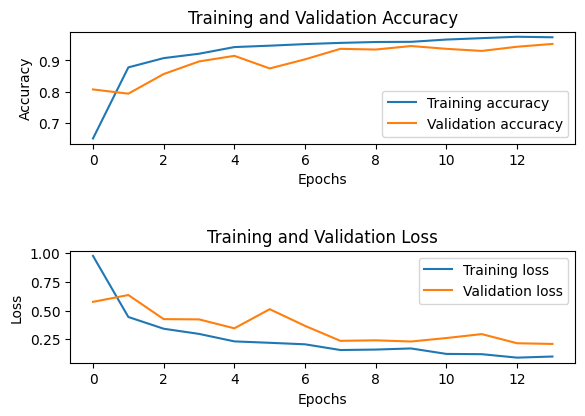

In [14]:
# Plot Visualisasi dari Training dan Validation
def plot_graphs(history, metric):
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.legend(loc='best')
    plt.title('Training and Validation ' + metric.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())

plt.subplot(2, 1, 1)
plot_graphs(history, 'accuracy')

plt.subplot(2, 1, 2)
plot_graphs(history, 'loss')

plt.tight_layout(pad=3.0)
plt.show()